In [2]:
###利用albumentations对图像进行扩增
import os
import albumentations as A
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import imgaug
from sklearn.model_selection import train_test_split
import shutil


def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

if __name__ == '__main__':
    inpath = r"D:\ImageClassfication\植物图像库合并"
    train_path = r"D:\ImageClassfication\Image\train"
    valid_path = r"D:\ImageClassfication\Image\valid"
    test_path = r"D:\ImageClassfication\Image\test"

    transform1 = A.Compose([A.HorizontalFlip(p=0.5),
                            A.RandomBrightnessContrast(p=0.2),
                            ])
    transform2 = A.Compose([A.VerticalFlip(p=0.5),
                           A.RandomRotate90(p=0.5),
                            ])
    transform3 = A.Compose([A.ShiftScaleRotate(p=1),
                            A.Blur(p=1.0),
                            ])
    transform4 =A.Compose([A.Resize(height=640, width=640),
                           A.Rotate(),
                           ])
    transform5 =A.Compose([A.Rotate(),
                           A.GaussianBlur(sigma_limit=9, p=0.5),
                           A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                           ])
    transform6 =A.Compose([A.Rotate(),
                           A.GaussianBlur(sigma_limit=9, p=0.5),
                           A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                           ])
    transform7 =A.Compose([A.Blur(blur_limit=3),
                           A.OpticalDistortion(),
                           A.GridDistortion(),
                           A.HueSaturationValue(),
                           ])
    transform8 = A.Compose([A.CLAHE(),
                           A.RandomRotate90(),
                           A.Transpose(),
                           A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
                           ])
    transform9 = A.Compose([A.RandomRotate90(),
                            A.Transpose(),
                            A.OneOf([
                                A.IAAAdditiveGaussianNoise(),
                                A.GaussNoise(),
                            ], p=0.2),
                            A.HueSaturationValue(p=0.3),
                            ])
    transform10 = A.Compose([A.Flip(),
                            A.OneOf([A.MotionBlur(p=.2),
                                     A.MedianBlur(blur_limit=3, p=0.1),
                                     A.Blur(blur_limit=3, p=0.1),
                                     ], p=0.2),
                            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=90, p=0.2),
                             ])
    transform11 = A.Compose([A.OneOf([A.OpticalDistortion(p=0.3),
                                     A.GridDistortion(p=.1),
                                     A.IAAPiecewiseAffine(p=0.3),
                                     ], p=0.2),
                             A.OneOf([A.CLAHE(clip_limit=2),
                                     A.IAASharpen(),
                                     A.IAAEmboss(),
                                     A.RandomBrightnessContrast(),
                                     ], p=0.3),
                             ])
    transform = [transform1,transform2,transform3,transform4,transform5,transform6,
                 transform7,transform8,transform9,transform10,transform11]
    plantname = os.listdir(inpath)
    for f in plantname:
        plant_dsr = os.path.join(inpath,f)
        plant_list = glob.glob(os.path.join(plant_dsr,"*"))
        count = len(plant_list)
        train_list,valid_list= train_test_split(plant_list,test_size=0.02,random_state=42)
        train_count = len(train_list)
        valid_count = len(valid_list)
        if valid_count < 2:
            valid_list = random.sample(plant_list,2)
            test_list = random.sample(plant_list,2)
        else:
            valid_list,test_list = train_test_split(valid_list,test_size=0.5,random_state=1)
        test_count = len(test_list)
        rest_count = 500 - train_count
        train_plantname = os.path.join(train_path,f)
        valid_plantname = os.path.join(valid_path,f)
        test_plantname = os.path.join(test_path,f)
        if os.path.exists(train_plantname) or os.path.exists(valid_plantname) or os.path.exists(test_plantname):     #如果该文件已经复制则直接跳过
            continue
        if not os.path.exists(train_plantname):
            os.makedirs(train_plantname)
        if not os.path.exists(valid_plantname):
            os.makedirs(valid_plantname)
        if not os.path.exists(test_plantname):
            os.makedirs(test_plantname)
        for valid_f in valid_list:
            shutil.copy(valid_f,valid_plantname)
        for test_f in test_list:
            shutil.copy(test_f,test_plantname)

        if train_count >= 500:                     #图像数量满足大于500的植物则直接进行拷贝
            for train_f in train_list:
                if os.path.basename(train_f).endswith(".jpg") and not os.path.exists(os.path.join(train_plantname,os.path.basename(train_f))):       #如果图像为jpg格式直接拷贝
                    shutil.copy(train_f,train_plantname)
                else:     #否则进行格式转换
                    try:      #异常处理防止因个别图像格式或错误造成程序停止
                        outname_plant = os.path.join(train_plantname,os.path.basename(train_f).split(".")[0] + ".jpg")      #将图像格式全部转换为jpg
                        imgc = Image.open(train_f)
                        imgc = imgc.convert("RGB")
                        imgc.save(outname_plant)
                    except OSError as e:
                        print(train_f + ":" + e)
        else:                                       #图像数量不足首先拷贝数量不足的图像，其次通过数据扩增方式补充剩余图像
            transform_lits = list()      #对每个图像执行transform存到transform_lits后随机取出
            ###以上首先拷贝已有图像，然后扩增图像至达到数量要求
            for train_f in train_list:
                if os.path.basename(train_f).endswith(".jpg") and not os.path.exists(os.path.join(train_plantname,os.path.basename(train_f))):       #如果图像为jpg格式直接拷贝
                    shutil.copy(train_f,train_plantname)
                else:      #否则进行格式转换
                    try:
                        outname_plant = os.path.join(train_plantname,os.path.basename(train_f).split(".")[0] + ".jpg")      #将图像格式全部转换为jpg
                        imgc = Image.open(train_f)
                        imgc = imgc.convert("RGB")
                        imgc.save(outname_plant)
                    except OSError as e:
                        print(train_f + ":" + e)
                #数据扩增
                img = Image.open(train_f)
                img = img.convert("RGB")
                image = np.array(img)
                for transf in transform:
                    try:
                        transformed = transf(image=image)
                        transform_lits.append(transformed)
                    except Exception as e:
                        print(train_f + ":" + e)
            transformed_count = len(transform_lits)     #获取扩增后图像数量
            if transformed_count >= rest_count:
                transformed_select = random.sample(transform_lits,rest_count)
                for i,transformed_dict in enumerate(transformed_select):
                    transformed_img = Image.fromarray((transformed_dict["image"] * 255).astype(np.uint8))
                    #transformed_img = Image.fromarray(transformed_dict["image"])
                    transformed_img.save(os.path.join(train_plantname,f"transform_{i}.jpg"))
            else:
                moretransform_count = rest_count - transformed_count
                ready_transform_count = int(moretransform_count / 11) + 1
                ready_transform_img = random.sample(train_list,ready_transform_count)
                for ii,ready_img in enumerate(ready_transform_img):
                    imgobj = Image.open(ready_img)
                    imgobj = imgobj.convert("RGB")
                    imagearray = np.array(imgobj)
                    for jj,rest_transform in enumerate(transform):
                        ready_transformed = rest_transform(image=imagearray)
                        ready_transformed_img = Image.fromarray((ready_transformed["image"] * 255).astype(np.uint8))
                        #ready_transformed_img = Image.fromarray(ready_transformed["image"])
                        ready_transformed_img.save(os.path.join(train_plantname,f"transform_{ii}_{jj}.jpg"))
        print(f)

硬毛棘豆
硬质早熟禾
硬阿魏
碱地风毛菊
碱菀
碱蒿
碱蓬
秀丽马先蒿
种阜草
秦艽
稠李
稷
穗花马先蒿
穿叶眼子菜
突节老鹳草
窄叶蓝盆花
笃斯越橘
笔管草
等齿委陵菜
箭头唐松草
篦苞风毛菊
篦齿眼子菜
米口袋
粉报春
粗根鸢尾
粗毛山柳菊
糖芥
糙叶败酱
糙叶黄芪
糙隐子草
紫斑风铃草
紫筒草
紫羊茅
紫花地丁
紫花杯冠藤
紫花野菊
紫苞鸢尾
紫菀
紫萍
繁缕
繁缕景天
繸瓣繁缕
红柴胡
红瑞木
红砂
红纹马先蒿
红色马先蒿
红花鹿蹄草
红足蒿
红车轴草
红轮狗舌草
线叶旋覆花
线叶花旗杆
线叶菊
细叶假还阳参
细叶卷耳
细叶早熟禾
细叶水蔓菁
细叶沙参
细叶狸藻
细叶白头翁
细叶益母草
细叶繁缕
细叶蓼
细叶蚊子草
细叶韭
细叶鸢尾
细叶鸦葱
细叶黄芪
细枝盐爪爪
细齿草木樨
绒毛胡枝子
绒背蓟
绢毛山莓草
绢毛绣线菊
绣线菊
绳虫实
绵刺
绵枣儿
绶草
缘毛鹅观草
缬草
罗布麻
羊柴
羊茅
羊草
美花风毛菊
羽叶鬼针草
羽节蕨
羽茅
翠雀
翻白繁缕
翼茎风毛菊
老牛筋
老芒麦
耧斗菜
耧斗菜叶绣线菊
耳叶蓼
聚花风铃草
肉苁蓉
肥披碱草
胀果芹
胡枝子
脓疮草
脬囊草
腺毛唐松草
腺毛委陵菜
舞鹤草
艾
芍药
芒颖大麦草
芦苇
芨芨草
花旗杆
花楸树
花苜蓿
花蔺
花锚
芹叶铁线莲
苇状看麦娘
苍术
苍耳
苜蓿
苣荬菜
苦参
苦荞麦
苦豆子
苦马豆
茜草
茵陈蒿
草地早熟禾
草地老鹳草
草地风毛菊
草木樨
草木樨状黄芪
草本威灵仙
草沙蚕
草玉梅
草瑞香
草苁蓉
草问荆
草麻黄
荒漠锦鸡儿
荠
荩草
荻
莎菀
莓叶委陵菜
莲座蓟
莳萝蒿
菊三七
菊叶委陵菜
菊花
菊蒿
菖蒲
菟丝子
菰
菱叶藜
菵草
菹草
萝藦
萹蓄
葶苈
蒌蒿
蒙古扁桃
蒙古白头翁
蒙古糖芥
蒙古羊柴
蒙古羊茅
蒙古荚蒾
蒙古莸
蒙古蒿
蒙古虫实
蒙古韭
蒙古黄芪
蒙疆苓菊
蒲公英
蒺藜
蓍
蓍状亚菊
蓝刺头
蓝堇草
蓝萼香茶菜
蓟
蓬子菜
蓼子朴
蔓茎蝇子草
蔓黄芪
蕤核
蕨
蕨麻
薄荷
薤白
藜
藜芦
藜芦獐牙菜
藤长苗
虉草
虎尾草
蚊子草
蚊母草
蛇床
蛛丝蓬
蜻蜓兰
蝙蝠葛
血见愁
裂叶堇菜
裂叶荆芥
裂叶蒿
裂叶马兰
裸果木
西伯利亚三毛草
西伯利亚剪股颖
西伯利亚早熟禾
西伯利亚滨藜
西伯利亚紫菀
西伯利亚蓼
西伯利亚败酱
西伯利亚远志
西伯利亚铁线莲
角盘兰
角茴香
角

In [33]:
#对分类表进行分解，将分类信息分开并进行统计
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["SimHei"]    #用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False    #用来正常显示中文标签
if __name__ == '__main__':
    table = r"E:\论文\草地植物分类\植物信息表_new(831).xlsx"
    df = pd.read_excel(table)
    for i in range(df.shape[0]):
        df.loc[i,"界"] = df.loc[i,"分类系统"].split("\n")[0].split(" ")[1].split("(")[0].split("-")[1]
        df.loc[i,"门"] = df.loc[i,"分类系统"].split("\n")[1].split(" ")[1].split("(")[0].split("-")[1]
        df.loc[i,"纲"] = df.loc[i,"分类系统"].split("\n")[2].split(" ")[1].split("(")[0].split("-")[1]
        df.loc[i,"目"] = df.loc[i,"分类系统"].split("\n")[3].split(" ")[1].split("(")[0].split("-")[1]
        df.loc[i,"科"] = df.loc[i,"分类系统"].split("\n")[4].split(" ")[1].split("(")[0].split("-")[1]
        df.loc[i,"属"] = df.loc[i,"分类系统"].split("\n")[5].split(" ")[1].split("(")[0].split("-")[1]

In [58]:
df.loc[:,"属"].value_counts()

蒿属      23
风毛菊属    14
堇菜属     12
鸢尾属     12
黄芪属     11
        ..
木蓼属      1
胡颓子属     1
沙蓬属      1
沙鞭属      1
茄属       1
Name: 属, Length: 409, dtype: int64

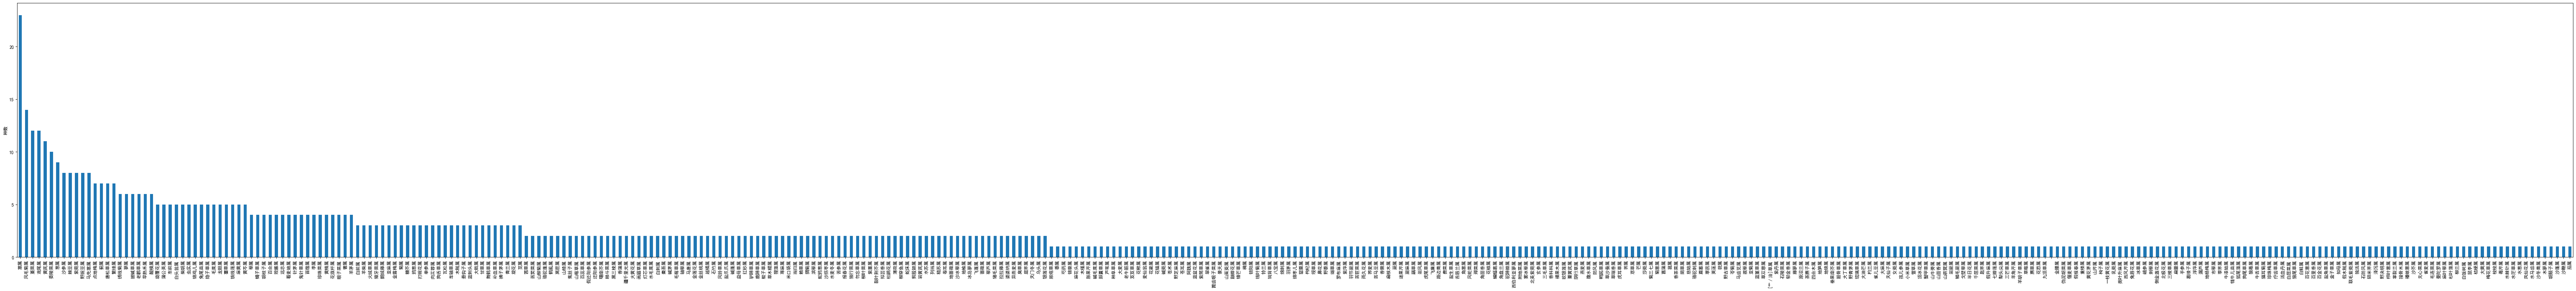

In [52]:
plt.figure(figsize=(100,10))
df.loc[:,"属"].value_counts().plot(kind="bar")
plt.ylabel("种数")
plt.savefig("属.jpg",dpi=300)

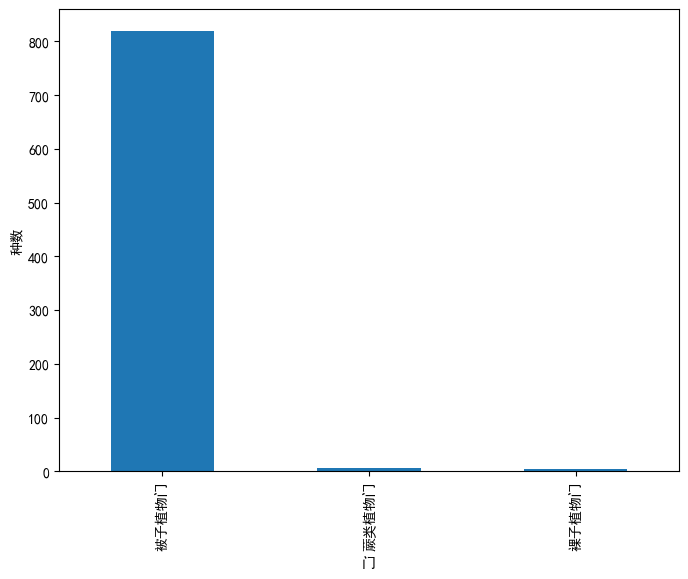

In [54]:
plt.figure(figsize=(8,6))
df.loc[:,"门"].value_counts().plot(kind="bar")
plt.xlabel("门")
plt.ylabel("种数")
plt.savefig("门.jpg",dpi=300)

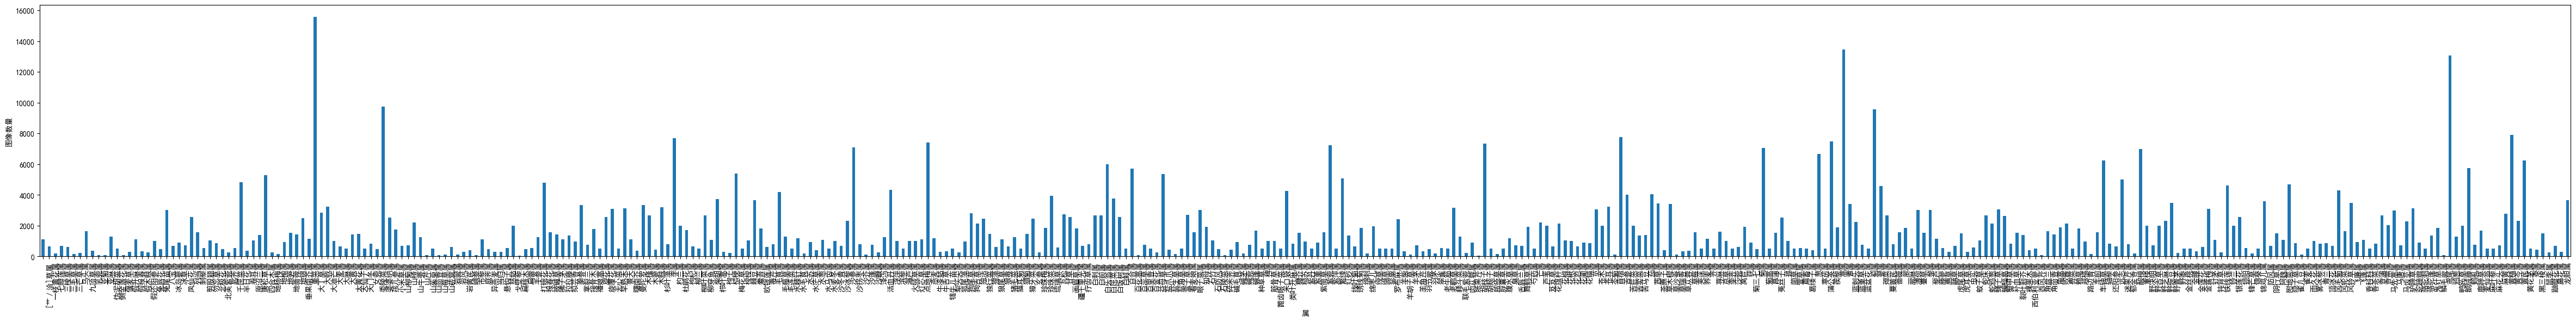

In [74]:
plt.figure(figsize=(60,6))
df.groupby(by=["属"])["图像数量"].sum().plot(kind="bar")
plt.xlabel("属")
plt.ylabel("图像数量")
plt.savefig("属_count.jpg",dpi=300)

In [61]:
gang = df.groupby(by=["纲"])["图像数量"].sum()

纲
木兰纲    668678
木贼纲      5696
松纲       2779
Name: 图像数量, dtype: int64

In [62]:
df.groupby(by=["目"])["图像数量"].sum()

目
伞形目       14310
十字花目      12901
卫矛目         500
唇形目       57150
天门冬目      46151
山茱萸目        500
川续断目       5902
无患子目       6495
木贼目        3202
杜鹃花目      21480
桃金娘目       7982
檀香目         764
毛茛目       42402
水龙骨目       2494
泽泻目       10434
牻牛儿苗目      3657
百合目        9708
石竹目       60176
禾本目       50486
紫草目        9499
茄目        18904
菊目       113711
菖蒲目        1536
葡萄目        2488
葫芦目        2690
蒺藜目        3069
蔷薇目       41475
虎耳草目       8027
豆目        62332
金虎尾目      23113
锦葵目        4528
鸭跖草目       2993
麻黄目        2779
龙胆目       23315
Name: 图像数量, dtype: int64

In [63]:
df.groupby(by=["科"])["图像数量"].sum()

科
五福花科     2288
亚麻科      1291
伞形科     14310
兰科       9352
冷蕨科       472
        ...  
鸢尾科     13070
鸭跖草科     1996
麻黄科      2779
鼠李科       262
龙胆科      7724
Name: 图像数量, Length: 88, dtype: int64

In [64]:
df.groupby(by=["属"])["图像数量"].sum()

属
           1088
[艹／洽]草属     660
一枝黄花属       180
七瓣莲属        694
三棱草属        624
           ... 
黑三棱属       1500
鼠李属         262
鼬瓣花属        665
鼻花属         301
龙胆属        3636
Name: 图像数量, Length: 409, dtype: int64

In [ ]:
##通过selenium模拟浏览器批量下载图像数据
import os
from bs4 import BeautifulSoup
import requests
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
import selenium.webdriver.support.ui as ui
from selenium.webdriver.chrome.options import Options
from urllib.request import urlopen
from urllib.error import URLError
from time import sleep
import re
import pandas as pd
import pyautogui
import time
import pickle
import random

if __name__ == '__main__':
    table = r"D:\ImageClassfication\植物信息表.xlsx"
    df = pd.read_excel(table)
    driver = webdriver.Chrome()
    driver.implicitly_wait(2)
    driver.maximize_window()
    ###########-----------------------模拟登陆-----------------------------
    logurl = "https://ppbc.iplant.cn/sp/41181"
    driver.get(logurl)
    for i in range(df.shape[0]):
        plantname = df.loc[i,"名称"]
        try:
            driver.find_element(By.ID,"txt_key").send_keys(plantname)
            driver.find_element(By.ID,"but_search").click()
            scitfullname = driver.find_element(By.XPATH,'//*[@id="result"]/div/div[1]/div[2]').text
            scicname = re.findall(r"\w+",scitfullname)[1:]
            str = " ".join(scicname)
            df.loc[i,"学名简写"] = str
        except Exception as e:
            print(e)
    with pd.ExcelWriter(r"D:\ImageClassfication\植物信息表_new.xlsx") as writer:
        df.to_excel(writer)

In [8]:
#判断图像命名是否存在中文，如果存在则替换为随机数
import os
import glob
from PIL import Image
import random
def is_contain_chinese(check_str):
    """
    判断字符串中是否包含中文
    :param check_str: {str} 需要检测的字符串
    :return: {bool} 包含返回True， 不包含返回False
    """
    for ch in check_str:
        if u'\u4e00' <= ch <= u'\u9fff':
            return True
    return False
if __name__ == '__main__':
    basepath = r"D:\ImageClassfication\Image\train"
    for f in glob.glob(os.path.join(basepath,"*","*.jpg")):
        basename = os.path.basename(f)
        if is_contain_chinese(basename):
            newname = "".join([str(i) for i in random.sample([1,2,3,4,5,6,7,8,9,10],6)]) + ".jpg"    #生成随机数
            #dirname = os.path.dirname(f)
            #os.rename(f,os.path.join(dirname,newname))
            #print(newname)


In [7]:
#判断图像是否完整，如果不完整删除并记录文件位置
import os
import glob
from PIL import Image
import random
def is_contain_chinese(check_str):
    """
    判断字符串中是否包含中文
    :param check_str: {str} 需要检测的字符串
    :return: {bool} 包含返回True， 不包含返回False
    """
    for ch in check_str:
        if u'\u4e00' <= ch <= u'\u9fff':
            return True
    return False

if __name__ == '__main__':
    basepath = r"D:\ImageClassfication\Image\train"
    for f in glob.glob(os.path.join(basepath,"*","*.jpg")):
        try:
            img = Image.open(f)  # open the image file
            img.verify()  # verify that it is, in fact an image
        except (IOError, SyntaxError) as e:
            print(f)
            os.remove(f)

C:\JupyterLab\JupyterDesktopAPPServer\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
